# MLP Modeling - 6
5에서는 publisher 데이터까지 넣어보자
rnn 적용

마구 생각:
 * vocab도 만들어야 하고.. tokenizing도 해야될 듯?
 * mlpregressor에서 keras로 바꾸는 것도 필요

# Embedding은 이 링크 참고 (openai 또는 huggingface)
https://lsjsj92.tistory.com/657

In [1]:
import os
from datetime import datetime as dt

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
# import optuna

2023-04-27 16:15:15.799294: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-27 16:15:15.946285: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-27 16:15:16.729736: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/loca

## load data

In [2]:
train_df = pd.read_csv("open/train.csv", index_col='ID')
test_df = pd.read_csv("open/test.csv", index_col='ID')
sample_submission_df = pd.read_csv("open/sample_submission.csv")

train_df.shape, test_df.shape, sample_submission_df.shape

((871393, 9), (159621, 8), (159621, 2))

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 871393 entries, TRAIN_000000 to TRAIN_871392
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   User-ID              871393 non-null  object 
 1   Book-ID              871393 non-null  object 
 2   Book-Rating          871393 non-null  int64  
 3   Age                  871393 non-null  float64
 4   Location             871393 non-null  object 
 5   Book-Title           871393 non-null  object 
 6   Book-Author          871393 non-null  object 
 7   Year-Of-Publication  871393 non-null  float64
 8   Publisher            871393 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 66.5+ MB


## preprocess data

In [4]:
train_users = train_df['User-ID'].unique()
train_books = train_df['Book-ID'].unique()

len(train_users), len(train_books)

(83256, 243441)

In [5]:
test_users = test_df['User-ID'].unique()
test_books = test_df['Book-ID'].unique()

len(test_users), len(test_books)

(21909, 62333)

In [6]:
len(set(train_users) | set(test_users)), len(set(train_books) | set(test_books))

(92101, 270056)

새로운 유저, 새로운 책이 분명 있음

In [7]:
train_df.head()

,User-ID,Book-ID,Book-Rating,Age,Location,Book-Title,Book-Author,Year-Of-Publication,Publisher
ID,,,,,,,,,
TRAIN_000000,USER_00000,BOOK_044368,8,23.0,"sackville, new brunswick, canada",Road Taken,Rona Jaffe,2001.0,Mira
TRAIN_000001,USER_00000,BOOK_081205,8,23.0,"sackville, new brunswick, canada",Macbeth (New Penguin Shakespeare),William Shakespeare,1981.0,Penguin Books
TRAIN_000002,USER_00000,BOOK_086781,0,23.0,"sackville, new brunswick, canada",Waverley (Penguin English Library),Walter Scott,1981.0,Penguin Books
TRAIN_000003,USER_00000,BOOK_098622,0,23.0,"sackville, new brunswick, canada",Mother Earth Father Sky,Sue Harrison,1991.0,Avon
TRAIN_000004,USER_00000,BOOK_180810,8,23.0,"sackville, new brunswick, canada",She Who Remembers,Linda Lay Shuler,1989.0,Signet Book


User feature
 * Age: int
 * Location: string

Book feature
 * Book-Title: string
 * Book-Author: string
 * Year-Of-Pulication: int
 * Publisher: string

특징의 분해 이전에 label 형태로도 해볼 수 있음

# Feature Selection

In [8]:
features = test_df.columns
features

Index(['User-ID', 'Book-ID', 'Age', 'Location', 'Book-Title', 'Book-Author',
       'Year-Of-Publication', 'Publisher'],
      dtype='object')

In [9]:
continuous_features = ['Age', 'Year-Of-Publication']
categorical_features = ['Location', 'Book-Title', 'Book-Author', 'Publisher']

In [10]:
train_df['Location'] = train_df['Location'].str.replace(' ', '')
train_df['Location_country'] = train_df['Location'].apply(lambda x: x.split(',')[-1])
train_df['Location_city'] = train_df['Location'].apply(lambda x: x.split(',')[-2])
train_df.drop(columns='Location', inplace=True)
train_df.head()

,User-ID,Book-ID,Book-Rating,Age,Book-Title,Book-Author,Year-Of-Publication,Publisher,Location_country,Location_city
ID,,,,,,,,,,
TRAIN_000000,USER_00000,BOOK_044368,8,23.0,Road Taken,Rona Jaffe,2001.0,Mira,canada,newbrunswick
TRAIN_000001,USER_00000,BOOK_081205,8,23.0,Macbeth (New Penguin Shakespeare),William Shakespeare,1981.0,Penguin Books,canada,newbrunswick
TRAIN_000002,USER_00000,BOOK_086781,0,23.0,Waverley (Penguin English Library),Walter Scott,1981.0,Penguin Books,canada,newbrunswick
TRAIN_000003,USER_00000,BOOK_098622,0,23.0,Mother Earth Father Sky,Sue Harrison,1991.0,Avon,canada,newbrunswick
TRAIN_000004,USER_00000,BOOK_180810,8,23.0,She Who Remembers,Linda Lay Shuler,1989.0,Signet Book,canada,newbrunswick


In [11]:
test_df['Location'] = test_df['Location'].str.replace(' ', '')
test_df['Location_country'] = test_df['Location'].apply(lambda x: x.split(',')[-1])
test_df['Location_city'] = test_df['Location'].apply(lambda x: x.split(',')[-2])
test_df.drop(columns='Location', inplace=True)
test_df.head()

,User-ID,Book-ID,Age,Book-Title,Book-Author,Year-Of-Publication,Publisher,Location_country,Location_city
ID,,,,,,,,,
TEST_000000,USER_00008,BOOK_047966,37.0,Birds of Prey: A Novel of Suspense,J.A. Jance,2002.0,Avon,usa,ohio
TEST_000001,USER_00008,BOOK_119494,37.0,Midnight Voices,JOHN SAUL,2003.0,Ballantine Books,usa,ohio
TEST_000002,USER_00008,BOOK_151775,37.0,Breaking Free : A Prescription for Personal an...,David M. Noer,1996.0,Jossey-Bass,usa,ohio
TEST_000003,USER_00008,BOOK_176255,37.0,Bitter Harvest,Ann Rule,1999.0,Pocket,usa,ohio
TEST_000004,USER_00008,BOOK_187307,37.0,Embraced by the Light,Betty J. Eadie,1994.0,Bantam Books,usa,ohio


# encoding

for location_country, publisher

In [12]:
from sklearn.preprocessing import OneHotEncoder

In [13]:
cont_encoder = OneHotEncoder(handle_unknown='ignore', dtype='bool')
train_country_array = cont_encoder.fit_transform(train_df[['Location_country']]).toarray()
test_country_array = cont_encoder.transform(test_df[['Location_country']]).toarray()

In [14]:
# pub_encoder = OneHotEncoder(handle_unknown='ignore', dtype='bool')
# train_publisher_array = pub_encoder.fit_transform(train_df[['Publisher']]).toarray()
# test_publisher_array = pub_encoder.transform(train_df[['Publisher']]).toarray()

# scaling

In [15]:
from sklearn.preprocessing import StandardScaler

In [16]:
scaler = StandardScaler()
train_cont_array = scaler.fit_transform(train_df[continuous_features])
test_cont_array = scaler.transform(test_df[continuous_features])

# merge prcessed data

In [17]:
train_cont_array.shape, train_country_array.shape#, train_publisher_array.shape

((871393, 2), (871393, 243))

In [18]:
# train_x = {
#     'input_continuous': train_cont_array,
#     'input_country': train_country_array,
# }

# test_x = {
#     'input_continuous': test_cont_array,
#     'input_country': test_country_array,
# }

train_x = [train_cont_array, train_country_array]#, train_publisher_array]
test_x = [test_cont_array, test_country_array]#, test_publisher_array]

In [19]:
# train_x = np.concatenate([train_cont_array, train_df[['Location_country']].values], axis=1) #train_publisher_array
# test_x = np.concatenate([test_cont_array, test_df[['Location_country']].values], axis=1) #test_publisher_array

# train_x.shape, test_x.shape

In [20]:
train_y = train_df['Book-Rating'].values
train_y.shape

(871393,)

In [21]:
# train_array = np.concatenate([train_cont_array, train_country_array, train_publisher_array], axis=1)
# test_array = np.concatenate([test_cont_array, test_country_array, test_publisher_array], axis=1)

# model

In [22]:
alpha = 0.001

In [23]:
train_country_array.shape[1]

243

In [24]:
def build_custom_model(input_dims):
    # define input tensor
    input_continuous = tf.keras.Input(shape=input_dims[0], dtype=tf.float32)
    input_country = tf.keras.Input(shape=input_dims[1], dtype='bool')
    # input_publisher = tf.keras.Input(shape=input_dims[2], dtype='bool')

    # embedding layer
    embed_country_layer = tf.keras.layers.Embedding(
        train_country_array.shape[1], 10)(input_country)

    # rnn layer
    country_layer = tf.keras.layers.SimpleRNN(
        10, return_sequences=False, dtype=np.float32)(embed_country_layer)

    # # embedding layer
    # embed_publisher_layer = tf.keras.layers.Embedding(
    #     train_country_array.shape[1], 10)(input_publisher)

    # # rnn layer
    # publisher_layer = tf.keras.layers.SimpleRNN(
    #     10, return_sequences=False, dtype=np.float32)(embed_publisher_layer)

    # concatenate
    x = tf.keras.layers.Concatenate(axis=-1)([input_continuous, country_layer])#, publisher_layer])
    # # concatenate
    # x = tf.keras.layers.Concatenate(axis=-1)([input_continuous, input_country])

    # hidden layer
    x = tf.keras.layers.Dense(
        64, activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(alpha))(x)

    # hidden layer
    x = tf.keras.layers.Dense(
        16, activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(alpha))(x)

    # output layer
    x = tf.keras.layers.Dense(1, activation='linear')(x)

    model = tf.keras.Model([input_continuous, input_country], x) #, input_publisher

    return model

In [25]:
learning_rate = 0.001
batch_size = 1024
epochs = 100

In [26]:
mirrored_strategy = tf.distribute.MirroredStrategy()

with mirrored_strategy.scope():
    model = build_custom_model(input_dims=[
        train_cont_array.shape[1], 
        train_country_array.shape[1], 
        # train_publisher_array.shape[1]
    ])

    # define optimizer Adam
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # model compile
    model.compile(optimizer=optimizer, loss='mse', metrics='mse')

2023-04-27 16:15:26.135499: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38220 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 243)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 243, 10)      2430        ['input_2[0][0]']                
                                                                                                  
 input_1 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 simple_rnn (SimpleRNN)         (None, 10)           210         ['embedding[0][0]']              
                                                                                              

In [28]:
history = model.fit(train_x, train_y, validation_split=.1, epochs=epochs, batch_size=batch_size)

Epoch 1/100
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2023-04-27 16:15:31.744151: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


766/766 [==============================] - 118s 146ms/step - loss: 15.0899 - mse: 15.0502 - val_loss: 14.7497 - val_mse: 14.7140
Epoch 2/100
766/766 [==============================] - 109s 143ms/step - loss: 14.8047 - mse: 14.7714 - val_loss: 14.7364 - val_mse: 14.7046
Epoch 3/100
766/766 [==============================] - 110s 143ms/step - loss: 14.7585 - mse: 14.7275 - val_loss: 14.7052 - val_mse: 14.6750
Epoch 4/100
766/766 [==============================] - 110s 143ms/step - loss: 14.7311 - mse: 14.7011 - val_loss: 14.7021 - val_mse: 14.6724
Epoch 5/100
766/766 [==============================] - 108s 141ms/step - loss: 14.7114 - mse: 14.6818 - val_loss: 14.6912 - val_mse: 14.6618
Epoch 6/100
766/766 [==============================] - 108s 141ms/step - loss: 14.7012 - mse: 14.6720 - val_loss: 14.7073 - val_mse: 14.6780
Epoch 7/100
766/766 [==============================] - 109s 142ms/step - loss: 14.6932 - mse: 14.6638 - val_loss: 14.6832 - val_mse: 14.6538
Epoch 8/100
766/766 [====

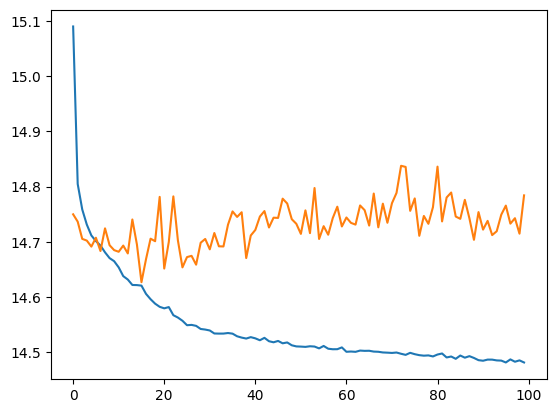

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [30]:
train_pred = model.predict(train_x)
train_pred

27232/27232 [==============================] - 550s 20ms/step


array([[3.3053591],
       [3.2349198],
       [3.2349198],
       ...,
       [3.5425441],
       [2.4353745],
       [3.0699022]], dtype=float32)

In [31]:
train_pred.shape

(871393, 1)

In [32]:
test_pred = model.predict(test_x)
test_pred

4989/4989 [==============================] - 100s 20ms/step


array([[2.6699731],
       [2.7041337],
       [2.4656327],
       ...,
       [3.4443479],
       [3.5405881],
       [3.6137817]], dtype=float32)

In [33]:
from sklearn.metrics import mean_squared_error

In [34]:
rmse = mean_squared_error(train_y, train_pred, squared=False)
rmse

3.804447646116466

In [35]:
sample_submission_df = pd.read_csv("open/sample_submission.csv")
sample_submission_df

,ID,Book-Rating
0,TEST_000000,0
1,TEST_000001,0
2,TEST_000002,0
3,TEST_000003,0
4,TEST_000004,0
...,...,...
159616,TEST_159616,0
159617,TEST_159617,0
159618,TEST_159618,0
159619,TEST_159619,0


In [36]:
mname = 'custom_dl'

In [37]:
def make_report(template, test_pred, mname):
    template['Book-Rating'] = test_pred
    now = dt.strftime(dt.now(), '%y-%m-%d')
    template.to_csv(f'results/{mname}-{now}.csv', index=False)
    
make_report(sample_submission_df, test_pred, mname)

test_rmse = 3.8036542165822924